In [1]:
import numpy as np
import os

def load_data_and_target(folder_name, percentage, range_folders_list=None):
    """
    지정된 백분율에 해당하는 선택된 범위의 데이터셋을 불러오고,
    data_folder 폴더에 있는 타겟 데이터도 불러오는 함수.
    """
    datasets = {}

    # 백분율 폴더 내의 모든 범위 폴더 탐색
    percentage_folder_path = os.path.join(folder_name, percentage)
    range_folders = os.listdir(percentage_folder_path) if range_folders_list is None else range_folders_list

    for range_folder in range_folders:
        range_path = os.path.join(percentage_folder_path, range_folder)
        if os.path.isdir(range_path):
            datasets[range_folder] = {}
            for dataset_type in ['train_first', 'train_second', 'test_first', 'test_second']:
                file_path = os.path.join(range_path, f"{dataset_type}_concatenated.npy")
                if os.path.exists(file_path):
                    datasets[range_folder][dataset_type] = np.load(file_path)
    
    # 타겟 데이터 불러오기
    target_data = {}
    for target_name in ['train_target', 'test_target']:
        file_path = os.path.join(folder_name, f"{target_name}_concatenated.npy")
        if os.path.exists(file_path):
            target_data[target_name] = np.load(file_path)

    return datasets, target_data

# 백분율 지정 및 데이터 불러오기
folder_name = 'data_folder'
percentage = "100%(sampling=100)"
model_name = "ConvLSTM"
# 모든 범위 폴더 리스트 지정 또는 부분적으로 지정
range_folders_list = os.listdir(os.path.join(folder_name, percentage))
# datasets, target_data = load_data_and_target(folder_name, percentage, range_folders_list[-3:])
datasets, target_data = load_data_and_target(folder_name, percentage, range_folders_list[:3])

# 불러온 데이터 형태 확인
for range_folder, data_dict in datasets.items():
    print(f"Range: {range_folder}")
    for key, data in data_dict.items():
        print(f"  {key} shape: {data.shape}")
for key, data in target_data.items():
    print(f"{key} shape: {data.shape}")

Range: 0~100
  train_first shape: (61456, 500, 4, 10)
  train_second shape: (61456, 500, 4, 5)
  test_first shape: (50224, 500, 4, 10)
  test_second shape: (50224, 500, 4, 5)
train_target shape: (61456,)
test_target shape: (50224,)


In [2]:
# 타겟 스케일러 불러오기
from joblib import load

# 저장된 scaler 객체 불러오기
scaler_target = load('./data_folder/scaler_target.joblib')

In [3]:
import gc
from tensorflow.keras.callbacks import EarlyStopping

def create_model():
    # 첫 번째 입력 스트림을 위한 ConvLSTM2D 레이어
    input1 = Input(shape=(500, 4, 10, 1))  # 배치 크기를 제외한 형태
    convlstm1 = ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='relu', return_sequences=False)(input1)
    batch_norm1 = BatchNormalization()(convlstm1)
    flat1 = Flatten()(batch_norm1)

    # 두 번째 입력 스트림을 위한 ConvLSTM2D 레이어
    # input_shape_second_CNN에서 배치 크기를 제외한 형태를 사용
    input2 = Input(shape=(500, 4, 5, 1))  # 가정: 두 번째 데이터셋도 동일한 방식으로 변환됨
    convlstm2 = ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='relu', return_sequences=False)(input2)
    batch_norm2 = BatchNormalization()(convlstm2)
    flat2 = Flatten()(batch_norm2)

    # 두 ConvLSTM 레이어의 출력을 결합
    combined = concatenate([flat1, flat2])

    # Dense 레이어 추가
    dense = Dense(64, activation='relu')(combined)
    output = Dense(1)(dense)

    # 모델 구성
    model = Model(inputs=[input1, input2], outputs=output)

    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.0001), loss=rmse)

    return model

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, Flatten, Dense, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
import tensorflow.keras.backend as K

# RMSE 손실 함수 정의
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)) + K.epsilon())

# EarlyStopping 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

num_repeats = 1
# 모든 모델과 RMSE를 저장할 구조 정의
all_models = {}  # 각 범위별 모든 모델 저장
all_rmse = {}  # 각 범위별 모든 RMSE 저장

# 최적 모델과 RMSE 저장할 구조 유지
best_models = {}
best_rmse = {}

for range_folder, data_dict in datasets.items():
    print(f"Training models for range: {range_folder}")
    all_models[range_folder] = []  # 현재 범위에 대한 모든 모델 저장
    all_rmse[range_folder] = []  # 현재 범위에 대한 모든 RMSE 저장
    
    best_rmse[range_folder] = np.inf  # 최소 RMSE를 찾기 위한 초기값 설정
    
    # 테스트 데이터 준비
    test_first_data = data_dict['test_first']
    test_second_data = data_dict['test_second']
    test_target = target_data['test_target']
    
    # 훈련 데이터 준비
    train_first_data = data_dict['train_first']
    train_second_data = data_dict['train_second']
    train_target = target_data['train_target']

    for i in range(num_repeats):
        print(f"Repeat {i+1}/{num_repeats}")
        model = create_model()  # 모델 생성 함수 호출
        
        # 모델 학습, verbose=1로 설정하여 학습 과정 출력
        history = model.fit(
            [train_first_data, train_second_data],
            train_target,
            epochs=5,
            batch_size=64,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=1  # 훈련 과정 로그를 상세하게 출력
        )

        # 모델 평가
        evaluation = model.evaluate(
            [test_first_data, test_second_data],
            test_target,
            batch_size=64,
            verbose=0  # 평가 과정은 간략하게 출력
        )
        
        current_rmse = evaluation  # 현재 RMSE
        all_models[range_folder].append(model)  # 현재 모델 저장
        all_rmse[range_folder].append(current_rmse)  # 현재 RMSE 저장
        
        # 최적 모델 및 RMSE 업데이트
        if current_rmse < best_rmse[range_folder]:
            best_rmse[range_folder] = current_rmse
            best_models[range_folder] = model
        
        gc.collect()

# 모든 모델과 RMSE 출력 (옵션)
for range_folder in datasets.keys():
    print(f"Range: {range_folder}, All RMSEs: {all_rmse[range_folder]}")

# 최적 모델과 RMSE 출력
for range_folder in datasets.keys():
    print(f"Range: {range_folder}, Best RMSE: {best_rmse[range_folder]}")

Training models for range: 0~100
Repeat 1/1
Epoch 1/5
769/769 [==============================] - 4217s 5s/step - loss: 0.1630 - val_loss: 0.1148
Epoch 2/5
769/769 [==============================] - 4135s 5s/step - loss: 0.1272 - val_loss: 0.1181
Epoch 3/5
769/769 [==============================] - 4054s 5s/step - loss: 0.1152 - val_loss: 0.1004
Epoch 4/5
769/769 [==============================] - 4171s 5s/step - loss: 0.1099 - val_loss: 0.1372
Epoch 5/5
769/769 [==============================] - 4114s 5s/step - loss: 0.1049 - val_loss: 0.0876
Range: 0~100, All RMSEs: [0.2208368480205536]
Range: 0~100, Best RMSE: 0.2208368480205536


Predicting and plotting for range: 0~100
Plot saved to model_performance_plots.png


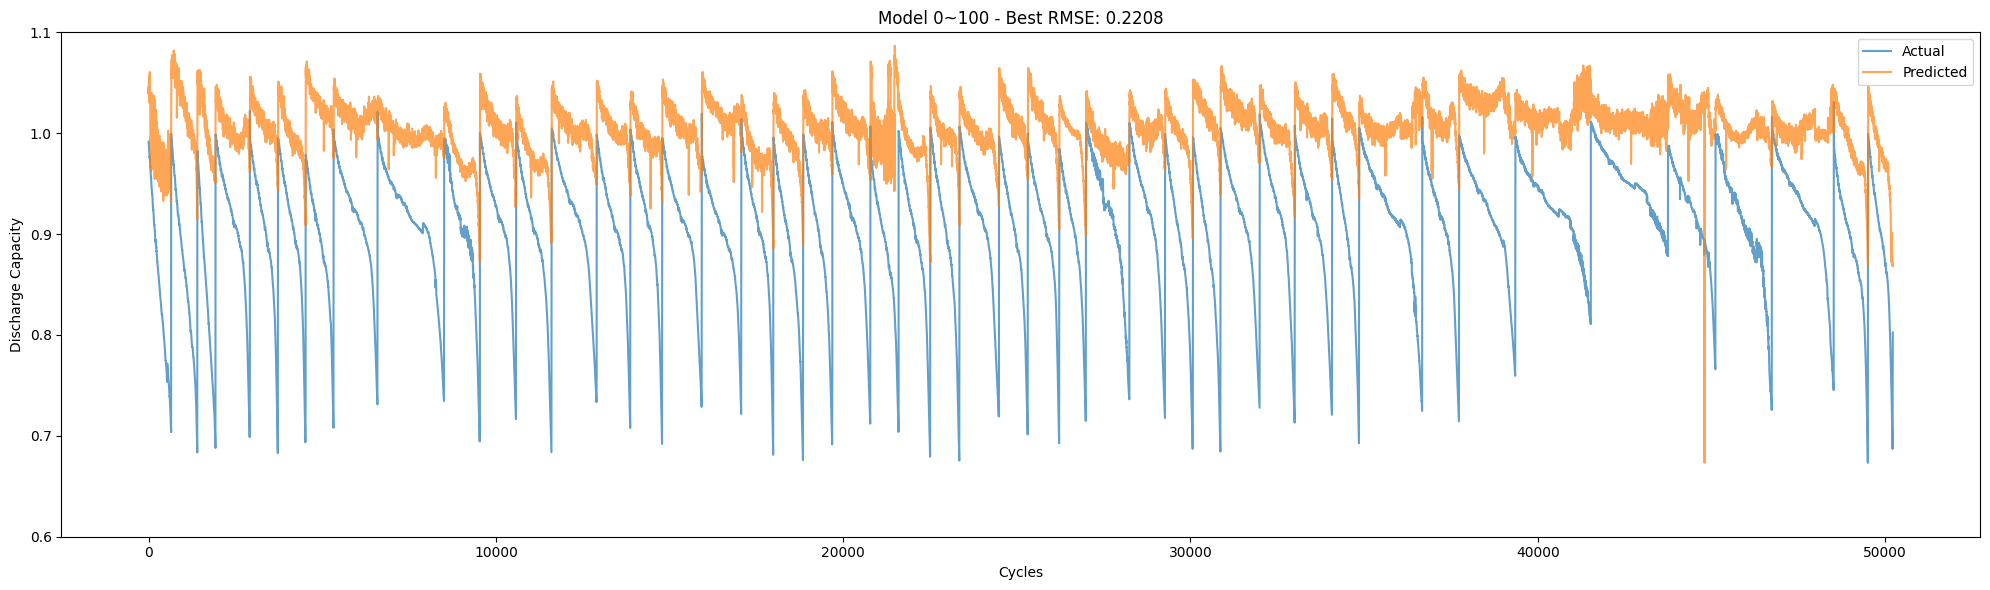

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 수정: best_models 딕셔너리를 사용
num_ranges = len(best_models.keys())
fig, axs = plt.subplots(num_ranges, 1, figsize=(20, 6 * num_ranges), squeeze=False) # 수정: squeeze=False로 단일 축 문제 해결

for idx, (range_folder, model) in enumerate(best_models.items()):
    print(f"Predicting and plotting for range: {range_folder}")

    # 테스트 데이터 준비
    test_first_data = datasets[range_folder]['test_first']
    test_second_data = datasets[range_folder]['test_second']
    test_target = target_data['test_target']  # 실제 데이터 사용

    # 모델로부터 예측 수행
    y_pred = model.predict([test_first_data, test_second_data], batch_size=64)

    # 실제 데이터와 예측 데이터의 역정규화 필요한 경우 여기에 코드 추가
    y_pred_transform = scaler_target.inverse_transform(y_pred)
    test_target_reshaped = test_target.reshape(-1, 1)
    test_target_transform = scaler_target.inverse_transform(test_target_reshaped)

    # 실제 값과 예측 값의 시각화
    best_rmse_score = best_rmse[range_folder]  # 최적의 RMSE 점수 사용
    axs[idx, 0].plot(test_target_transform, label='Actual', alpha=0.7)  # 수정: axs 인덱싱
    axs[idx, 0].plot(y_pred_transform, label='Predicted', alpha=0.7)  # 수정: axs 인덱싱
    axs[idx, 0].set_title(f'Model {range_folder} - Best RMSE: {best_rmse_score:.4f}')  # 수정: 최적의 RMSE 점수 표시
    axs[idx, 0].set_xlabel('Cycles')
    axs[idx, 0].set_ylabel('Discharge Capacity')
    axs[idx, 0].set_ylim([0.6, 1.1])
    axs[idx, 0].legend()

plt.tight_layout()

# 플롯을 파일로 저장
plt.savefig(f"model_performance_plots({model_name}, {percentage}, 3).png")
print("Plot saved to model_performance_plots.png")

plt.show()  # 화면에 플롯을 표시

In [6]:
import os

# 모델 저장 경로 지정
model_save_path = f"./models/{model_name}/{percentage}"
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path, exist_ok=True)

# 모든 모델 저장
for range_folder, models in all_models.items():
    # 해당 범위의 모든 모델을 저장하는 폴더 생성
    range_save_path = os.path.join(model_save_path, range_folder)
    os.makedirs(range_save_path, exist_ok=True)
    
    for i, model in enumerate(models):
        # 모델 파일 이름에 RMSE 포함
        model_file_name = f"model_{i+1}_rmse_{all_rmse[range_folder][i]:.4f}.h5"
        save_path = os.path.join(range_save_path, model_file_name)
        
        # 모델 저장
        model.save(save_path)
        print(f"Model {i+1} for range {range_folder} saved to {save_path}")

# 각 범위별로 최적의 모델 따로 저장
for range_folder, model in best_models.items():
    # 최적 모델 저장 경로 생성
    save_path = os.path.join(model_save_path, range_folder, f"best_model_rmse_{best_rmse[range_folder]:.4f}.h5")
    
    # 최적 모델 저장
    model.save(save_path)
    print(f"Best model for range {range_folder} saved to {save_path}")

Model 1 for range 0~100 saved to ./models/ConvLSTM/100%(sampling=100)\0~100\model_1_rmse_0.2208.h5
Best model for range 0~100 saved to ./models/ConvLSTM/100%(sampling=100)\0~100\best_model_rmse_0.2208.h5


In [7]:
import pygame
from moviepy.editor import VideoFileClip

# 영상 파일 경로 설정
video_path = "downloaded_video.mp4"

# 영상 클립 생성
clip = VideoFileClip(video_path)

# 영상의 처음 3초만 재생
clip = clip.subclip(3, 6)
clip.preview()

# Pygame 초기화
pygame.init()

# 재생이 끝난 후 Pygame 윈도우 종료
pygame.quit()

pygame 2.5.2 (SDL 2.28.3, Python 3.8.18)
Hello from the pygame community. https://www.pygame.org/contribute.html
